In [1]:
import pandas as pd 
import numpy as np
from datasets import CRSP
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm


In [2]:
crsp = CRSP()

df = crsp.df[['permno', 'date', 'ticker', 'prc', 'ret']].copy()

df = df.query("prc > 5").reset_index(drop=True)

df

,permno,date,ticker,prc,ret
0,10001,1986-02-28,GFGC,6.25000,0.020408
1,10001,1986-03-31,GFGC,6.31250,0.025200
2,10001,1986-04-30,GFGC,6.37500,0.009901
3,10001,1986-05-30,GFGC,6.31250,-0.009804
4,10001,1986-06-30,GFGC,6.12500,-0.013069
...,...,...,...,...,...
2844782,93436,2023-08-31,TSLA,258.07999,-0.034962
2844783,93436,2023-09-29,TSLA,250.22000,-0.030456
2844784,93436,2023-10-31,TSLA,200.84000,-0.197346
2844785,93436,2023-11-30,TSLA,240.08000,0.195379


In [3]:
# Formation Period: 12 months
# Use cummulative returns from t-13 to t-1 to form pairs.
# Rebalancing: Every 6 months

In [4]:
# Add extra date variables
df['mdt'] = df['date'].dt.strftime("%Y-%m")
df['year'] = df['date'].dt.strftime("%Y")
df['month'] = df['date'].dt.strftime("%m")

In [5]:
# Calculate Different Return Variables

holding_period = 6 # Alternative is 1
holding_period_var = f'ret_{holding_period}'

# Log Returns
df['logret'] = np.log1p(df['ret'])
df['cumret'] = df.groupby(['permno','year'])['logret'].cumsum().reset_index(drop=True)
df['cumret_lag'] = df.groupby('permno')['cumret'].shift(1)

# Holding period returns
df[holding_period_var] = df.groupby('permno')['logret'].rolling(holding_period,holding_period).sum().reset_index(drop=True)
df[holding_period_var] = df.groupby('permno')[holding_period_var].shift(-(holding_period-1))

df

,permno,date,ticker,prc,ret,mdt,year,month,logret,cumret,cumret_lag,ret_6
0,10001,1986-02-28,GFGC,6.25000,0.020408,1986-02,1986,02,0.020203,0.020203,NaN,0.021679
1,10001,1986-03-31,GFGC,6.31250,0.025200,1986-03,1986,03,0.024888,0.045090,0.020203,0.071156
2,10001,1986-04-30,GFGC,6.37500,0.009901,1986-04,1986,04,0.009852,0.054943,0.045090,0.043187
3,10001,1986-05-30,GFGC,6.31250,-0.009804,1986-05,1986,05,-0.009852,0.045090,0.054943,0.071801
4,10001,1986-06-30,GFGC,6.12500,-0.013069,1986-06,1986,06,-0.013155,0.031935,0.045090,0.136713
...,...,...,...,...,...,...,...,...,...,...,...,...
2844782,93436,2023-08-31,TSLA,258.07999,-0.034962,2023-08,2023,08,-0.035588,0.739624,0.775212,NaN
2844783,93436,2023-09-29,TSLA,250.22000,-0.030456,2023-09,2023,09,-0.030929,0.708694,0.739624,NaN
2844784,93436,2023-10-31,TSLA,200.84000,-0.197346,2023-10,2023,10,-0.219832,0.488863,0.708694,NaN
2844785,93436,2023-11-30,TSLA,240.08000,0.195379,2023-11,2023,11,0.178463,0.667326,0.488863,NaN


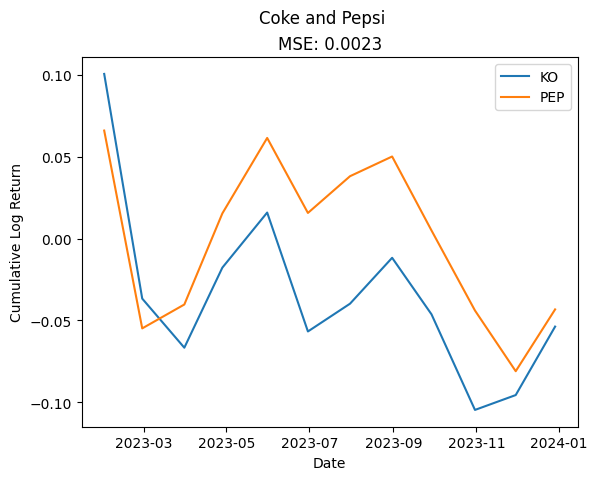

In [6]:
# Example of Pepsi and Coke cointegration
filtered = df[(df['year'] == '2023') & (df['permno'].isin([13856, 11308]))]
pivot = filtered.pivot(index='date', values='cumret_lag', columns='ticker')
mse = np.mean((pivot['PEP'] - pivot['KO'])**2)

for ticker, group in filtered.groupby('ticker'):
    plt.plot(group['date'], group['cumret_lag'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.suptitle('Coke and Pepsi')
plt.title(f"MSE: {round(mse,4)}")
plt.legend()
plt.show()

In [7]:
pivot = df.groupby(['permno','date'])['cumret_lag'].mean().reset_index().pivot(index='date', columns='permno', values='cumret_lag')
pivot['year'] = pivot.index.year
pivot

permno,10001,10002,10003,10006,10007,10008,10009,10010,10011,10012,...,93423,93426,93428,93429,93432,93433,93434,93435,93436,year
date,,,,,,,,,,,,,,,,,,,,,
1926-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-02-27,NaN,NaN,NaN,0.032208,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-03-31,NaN,NaN,NaN,-0.041901,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-04-30,NaN,NaN,NaN,-0.085576,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-05-28,NaN,NaN,NaN,-0.111824,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027572,-0.032608,NaN,NaN,NaN,NaN,NaN,NaN,0.775212,2023
2023-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.012553,-0.070472,NaN,NaN,NaN,NaN,NaN,NaN,0.739624,2023
2023-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011119,-0.140616,NaN,NaN,NaN,NaN,NaN,NaN,0.708694,2023


In [8]:
years = pivot['year'].unique()  # [2017, 2018]

mse_frame = pd.DataFrame(index=years, columns=pivot.columns, data=float("inf"))
pairs_frame = pd.DataFrame(index=years, columns=pivot.columns, data=None)

# Iterated through each year of data
for year in tqdm(years, desc='Processing years'):
    slice = pivot[pivot['year'] == year].dropna(axis=1, how='all').drop(columns=['year'])
    
    returns = slice.dropna(axis=1).T.dropna().T # This gets rid of stocks without 12 months of returns
    returns_array = returns.values
    
    # Loop through all combination of pairs
    for i, j in combinations(range(returns_array.shape[1]), 2):
        stock_i = returns.columns[i]
        stock_j = returns.columns[j]
        
        stock_i_returns = returns_array[:, i]
        stock_j_returns = returns_array[:, j]

        mse = np.mean((stock_i_returns - stock_j_returns) ** 2)

        # Keep pairs with the lowest MSE
        if mse < mse_frame.at[year, stock_i]:
            mse_frame.at[year, stock_i] = mse
            pairs_frame.at[year, stock_i] = returns.columns[j]

pairs_frame.to_csv("pairs_frame.csv", index=False)
mse_frame.to_csv("mse_frame.csv", index=False)


Processing years:  53%|█████▎    | 52/98 [02:54<02:34,  3.36s/it]


KeyboardInterrupt: 

In [65]:
pairs_frame = pd.read_csv("pairs_frame.csv")
mse_frame = pd.read_csv("mse_frame.csv")

mse_frame

,10001,10002,10003,10006,10007,10008,10009,10010,10011,10012,...,93423,93426,93428,93429,93432,93433,93434,93435,93436,year
1926,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1927,inf,inf,inf,0.004388,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1928,inf,inf,inf,0.005759,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1929,inf,inf,inf,0.021804,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1930,inf,inf,inf,0.009696,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2020,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2021,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2022,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [66]:
# Reformat mse and pairs dataframes
result_pairs_frame = pairs_frame.unstack().reset_index().rename(columns={'level_0': 'permno','level_1': 'year', 0: 'pair'})
result_mse_frame = mse_frame.unstack().reset_index().rename(columns={'level_0': 'permno','level_1':'year', 0: 'mse'})

# Merge
result_mse_frame = result_mse_frame.merge(result_pairs_frame, on=['permno','year'], how='left')

# Clean up final dataframe
result_mse_frame = result_mse_frame.sort_values(by=['year','mse'], ascending=True).dropna().reset_index(drop=True)

result_mse_frame.to_csv("pairs_yearly.csv",index=False)

result_mse_frame

,permno,year,mse,pair
0,11789,1926,0.001009,25486.0
1,10225,1926,0.001102,25486.0
2,13215,1926,0.001107,13741.0
3,10196,1926,0.001224,10225.0
4,12079,1926,0.001330,25486.0
...,...,...,...,...
155496,52708,2023,0.471855,63132.0
155497,63132,2023,0.529239,77447.0
155498,75573,2023,0.553209,76082.0
155499,13816,2023,0.562844,16696.0


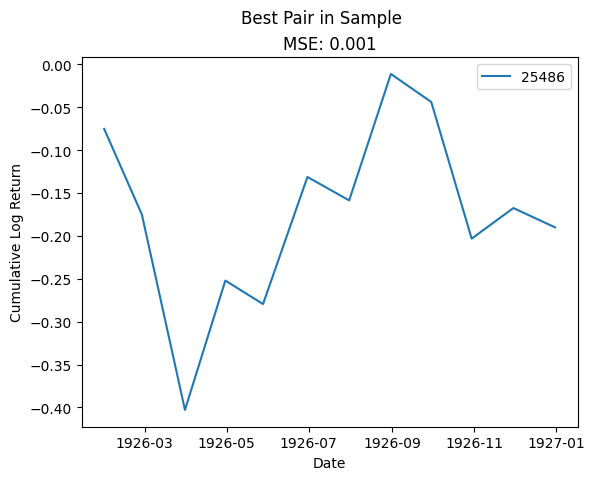

In [67]:
pair_1, year, mse, pair_2 = result_mse_frame.iloc[0]
filtered = df[(df['year'].astype(int) == year) & (df['permno'].isin([pair_1,pair_2]))]

for ticker, group in filtered.groupby('permno'):
    plt.plot(group['date'], group['cumret_lag'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.suptitle('Best Pair in Sample')
plt.title(f"MSE: {round(mse,4)}")
plt.legend()
plt.show()